# Notebook for carrying out clustering of agegroups

In [1]:

import os
os.environ["OMP_NUM_THREADS"] = '1' # To avoid memory leak on Windows
import numpy as np
import pandas as pd

from sklearn import mixture


import matplotlib.pyplot as plt
%matplotlib widget

# Load style
plt.style.use('PlotStyle.mplstyle')
import matplotlib.colors as colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

from datetime import datetime
from tqdm import tqdm


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))
print('Done loading packages')

saveFigures is set to: True
Done loading packages


In [2]:
# Set paths
pathData = '../Data/'
pathResults = '../Data/AnalysisResults'
pathFigs = '../Figures/'

In [3]:
# Flags and analysis parameters used in main analysis, set here to load correct results
numYears = 12 # Number of years on both sides of date to use for baseline calculations 
numYearsTot = (numYears*2) # The "name" of the baseline (i.e. +/- 5 years is a 10-year baseline, +/- 12 is a 24 year baseline)
thresholdExcess = 3 # Threshold (in terms of Z-scores) for identifying a day as having increased excess

# Additional parameters used
thresholdLower = 2 # Lower threshold used for determining the start and end of periods (in terms of Z-scores)
maxDaysBelowThreshold = 7 # Number of days below thresholdLower before a period of excess is "stopped"
minimumLengthOfEpidemic = 0 # Minimal number of days above thresholdExcess which is counted as a period of excess 
excessCountThreshold = 50 # Only save mortality crises with more than this number of excess deaths

# # Extra parameters for sensitivity analysis
# minimumLengthOfEpidemic = 4 # Minimal number of days above thresholdExcess which is counted as a period of excess 
# maxDaysBelowThreshold = 4 # Number of days below thresholdLower before a period of excess is "stopped"
# maxDaysBelowThreshold = 10 # Number of days below thresholdLower before a period of excess is "stopped" 
# maxDaysBelowThreshold = 20 # Number of days below thresholdLower before a period of excess is "stopped" 
# excessCountThreshold = 20 # Only save mortality crises with more than this number of excess deaths


# Determine filename to use for final results
# finalResultsFilename = 'AllCrises'+f'_Years{numYears}_Threshold{thresholdExcess}_LowerThreshold{thresholdLower}_MaxDaysBelow{maxDaysBelowThreshold}_minLength{minimumLengthOfEpidemic}_minCount{excessCountThreshold}'
finalResultsFilename = 'AllCrises'+f'_NonSmoothed_Years{numYears}_Threshold{thresholdExcess}_LowerThreshold{thresholdLower}_MaxDaysBelow{maxDaysBelowThreshold}_minLength{minimumLengthOfEpidemic}_minCount{excessCountThreshold}'
finalResultsFilename

'AllCrises_NonSmoothed_Years12_Threshold3_LowerThreshold2_MaxDaysBelow7_minLength0_minCount50'

In [4]:
# Define the agegroups analyzed
ageGroupsAll = [
    ['Total'],
    ['Stillborn','0'],
    ['1-4','5-9', '10-14'],
    ['15-19', '20-24', '25-29', '30-34', '35-39'],
    ['40-44', '45-49', '50-54', '55-59'],
    ['60-64', '65-69', '70-74', '75-79', '80+']
]

# And the names used for directories and filenames
ageGroupNamesAll = [
    'Total',
    'Infants_stillborn',
    '1-14',
    '15-39',
    '40-59',
    '60+'
]
ageGroups = ageGroupsAll[1:]
ageGroupNames = ageGroupNamesAll[1:]

# Load table with all crises

In [5]:
dfCrises = pd.read_csv(pathData + finalResultsFilename + '.csv')


dfCrises['Start'] = pd.to_datetime(dfCrises['Start'])
dfCrises['End'] = pd.to_datetime(dfCrises['End'])
# dfCrises['DayWithMostBurials'] = pd.to_datetime(dfCrises['DayWithMostBurials'])
dfCrises['DayWithMostDeaths'] = pd.to_datetime(dfCrises['DayWithMostDeaths'])

dfCrises = dfCrises.sort_values(by='Excess',ascending=False).reset_index(drop=True)


# Prepare data to use for clustering

In [6]:
# Use the columns with excess burials in each agegroup (and make sure to not use "Total" as well)
curCols = ageGroupNames
colsToUse = ['Exc_'+x for x in curCols]


In [7]:
# Get part of dataframe with age-specific excess
curdf = dfCrises[colsToUse].copy()

# Set negative values to 0
curdf[curdf < 0] = 0

# Calculate how big a proportion of all mortality is due to the given age group
fracdf = curdf.apply(lambda x: x/curdf.sum(axis=1)) 

# Get as array
curData = fracdf.to_numpy()


In [8]:

# Add the numbers in fracdf to the main dataframe, so they are also saved later
newCols = ['FracAll_'+x for x in curCols]
dfToAppend = fracdf.rename(columns=dict(zip(fracdf.columns,newCols)))

# Append the fraction
dfCrises = dfCrises.join(dfToAppend)

# Save the sum of excess to main dataframe
dfCrises['AgeSplitSumExc'] = curdf.sum(axis=1)

# Clustering

### Start by checking the aic and bic of different numbers of clusters

In [9]:
from sklearn import mixture

In [10]:
curData.shape

(418, 5)

In [11]:
# # Check AIC and BIC, with a specific subset of data

# dataToUse = curData[:100]
# # dataToUse = curData[:150]
# # dataToUse = curData[:200]
# # dataToUse = curData[:250]
# # dataToUse = curData

# fig,(ax,ax2) = plt.subplots(2,1)
# # for numClusters in tqdm(range(2,2)):
# for numClusters in tqdm(range(2,12)):
    
#     # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 50,random_state=123, covariance_type="tied") # Random_state set to have reproducibility when testing
#     clf = mixture.GaussianMixture(n_components=numClusters, n_init = 150,covariance_type="tied")
#     clf.fit(dataToUse)

#     ax.plot(numClusters,clf.aic(dataToUse),'s')
#     ax2.plot(numClusters,clf.bic(dataToUse),'s')

100%|██████████| 8/8 [04:40<00:00, 35.01s/it]


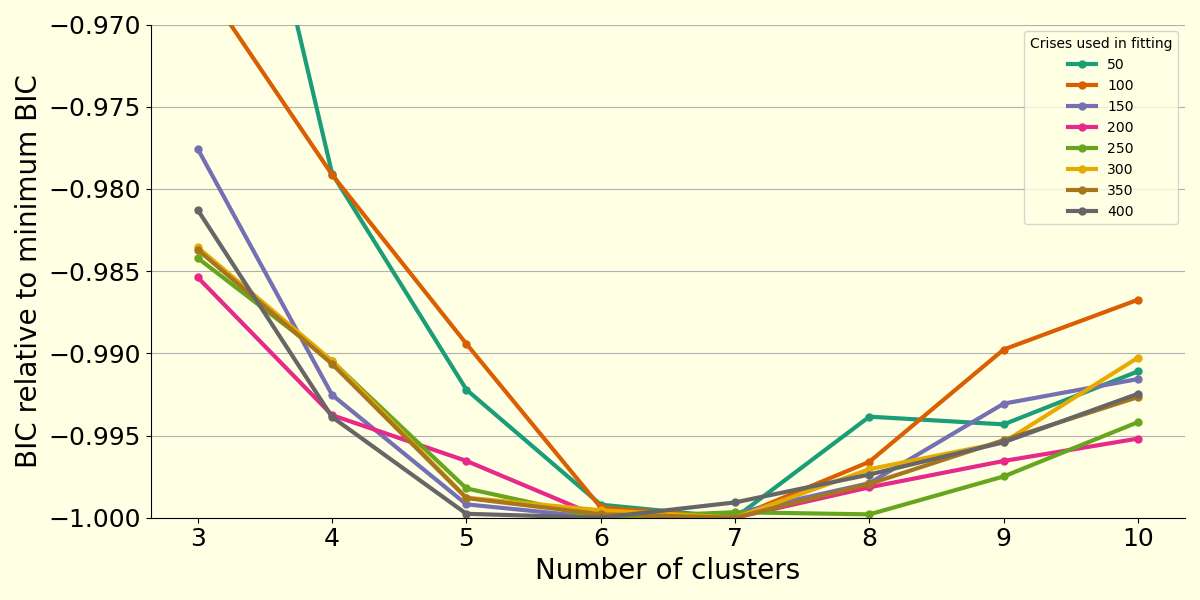

In [12]:
# Check BIC of a range of number of clusters and a range of subsets of data

clusterRange = np.arange(3,11)
dataRange = np.arange(50,len(curData),50)


# fig,(ax,ax2) = plt.subplots(2,1)
fig,ax2 = plt.subplots(figsize=(12,6))


for numData in tqdm(dataRange):
    curBics = []
    
    dataToUse = curData[:numData]

    # for numClusters in tqdm(clusterRange):
    for numClusters in clusterRange:

        
        # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 50,random_state=123, covariance_type="tied") # Random_state set to have reproducibility when testing
        clf = mixture.GaussianMixture(n_components=numClusters, n_init = 100,covariance_type="tied")
        clf.fit(dataToUse)

        curBics.append(clf.bic(dataToUse))

    ax2.plot(clusterRange,curBics / -np.min(curBics),'.-',label=numData)
        # ax2.plot(numClusters,clf.bic(dataToUse),'s')

ax2.legend(title= 'Crises used in fitting')
ax2.set_ylabel('BIC relative to minimum BIC')
ax2.set_xlabel('Number of clusters')
ax2.set_ylim([-1,-0.97])
    
if saveFigures:
    fig.savefig(pathFigs+'Supplementary_BIC')

In [13]:

import matplotlib.cm as cm
cmapBar = cm.get_cmap('rainbow',5)

dlen =1
# dlen = 10
curRange = range(10,len(curData)+dlen,dlen)
# dlen = 5
# curRange = range(150,200,dlen)
# curRange = curRange[::-1]


cmap = cm.get_cmap('jet',len(curRange)) 

# clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied",warm_start=True)

dfResClust0 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClust1 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClust3 = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
dfResClustLast = pd.DataFrame(
    index=curRange,
    columns=np.arange(5)
)
from tqdm import tqdm
for i,maxData in enumerate(tqdm(curRange)):
    
    curColor = cmap(i)

    dataToUse = curData[:maxData]
    # numClusters = 8
    numClusters = 6
    clf = mixture.GaussianMixture(n_components=numClusters, n_init = 100,random_state=0, covariance_type="tied")
    # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 20, covariance_type="tied")

    clf.fit(dataToUse)


    dfMeans = pd.DataFrame(clf.means_)
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[0],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust0.loc[maxData] = dfMeans.loc[0]
    
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[1],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust1.loc[maxData] = dfMeans.loc[0]
    
    # curSortIndex = dfMeans.cumsum(axis=1).sort_values(by=[0,1,2,3],ascending=False).index
    curSortIndex = dfMeans.sort_values(by=[3],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClust3.loc[maxData] = dfMeans.loc[0]

    
    curSortIndex = dfMeans.sort_values(by=[4],ascending=False).index
    # curSortIndex = dfMeans.sort_values(by=[0,1,2,3],ascending=False).index
    dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)
    dfResClustLast.loc[maxData] = dfMeans.loc[0]
    


C:\Users\rakrpe\AppData\Local\Temp\ipykernel_27792\4161663162.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapBar = cm.get_cmap('rainbow',5)
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_27792\4161663162.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet',len(curRange))
100%|██████████| 409/409 [31:13<00:00,  4.58s/it]


In [16]:
# len(curData)

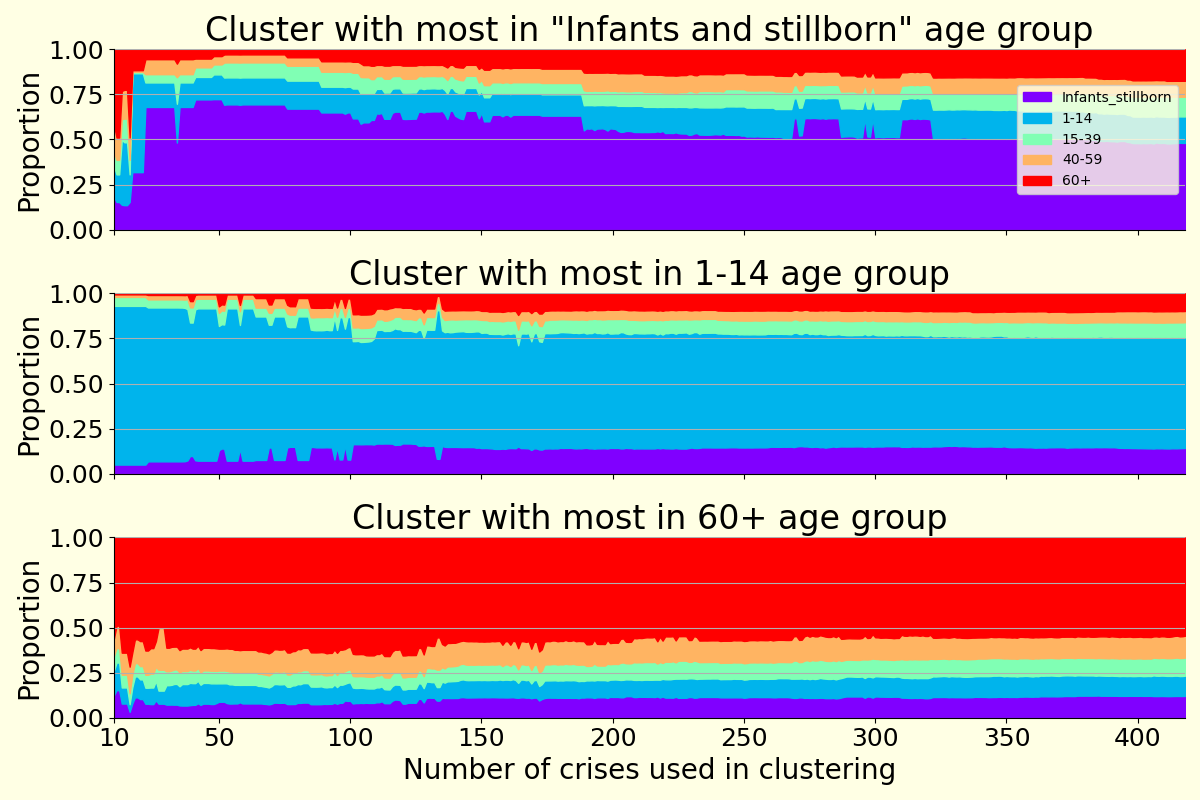

In [17]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True)




dfToPlot = dfResClust0.cumsum(axis=1)
dfToPlot = dfToPlot.astype('float')
ax = ax1 
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0),label=ageGroupNames[0])
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5),label=ageGroupNames[1])
ax.fill_between(curRange,dfToPlot[2],dfToPlot[1],color=cmapBar(2/5),label=ageGroupNames[2])
ax.fill_between(curRange,dfToPlot[3],dfToPlot[2],color=cmapBar(3/5),label=ageGroupNames[3])
ax.fill_between(curRange,dfToPlot[4],dfToPlot[3],color=cmapBar(4/5),label=ageGroupNames[4])

dfToPlot = dfResClust1.cumsum(axis=1)
dfToPlot = dfToPlot.astype('float')
ax = ax2
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0),label=ageGroupNames[0])
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5),label=ageGroupNames[1])
ax.fill_between(curRange,dfToPlot[2],dfToPlot[1],color=cmapBar(2/5),label=ageGroupNames[2])
ax.fill_between(curRange,dfToPlot[3],dfToPlot[2],color=cmapBar(3/5),label=ageGroupNames[3])
ax.fill_between(curRange,dfToPlot[4],dfToPlot[3],color=cmapBar(4/5),label=ageGroupNames[4])

dfToPlot = dfResClustLast.cumsum(axis=1)
dfToPlot = dfToPlot.astype('float')
ax = ax3
ax.fill_between(curRange,dfToPlot[0],color=cmapBar(0))
ax.fill_between(curRange,dfToPlot[1],dfToPlot[0],color=cmapBar(1/5))
ax.fill_between(curRange,dfToPlot[2],dfToPlot[1],color=cmapBar(2/5))
ax.fill_between(curRange,dfToPlot[3],dfToPlot[2],color=cmapBar(3/5))
ax.fill_between(curRange,dfToPlot[4],dfToPlot[3],color=cmapBar(4/5))

ax.set_xlim([curRange[0],curRange[-1]])
ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.5,0.75,1])
# ax.set_xticks([10,50,100,150,200,250,300,320])
ax.set_xticks([10,50,100,150,200,250,300,350,400])

ax1.set_title('Cluster with most in "Infants and stillborn" age group')
ax2.set_title('Cluster with most in 1-14 age group')
ax3.set_title('Cluster with most in 60+ age group')

ax1.set_ylabel('Proportion')
ax2.set_ylabel('Proportion')
ax3.set_ylabel('Proportion')


ax1.legend(loc='center right')

ax3.set_xlabel('Number of crises used in clustering')

fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs + 'Clustering_NumCrisesSensitivity')


In [26]:

# clusterRange = np.arange(3,11)
# dataRange = np.arange(50,len(curData),50)


# # fig,(ax,ax2) = plt.subplots(2,1)
# # fig,ax2 = plt.subplots(figsize=(12,6))


# for numData in tqdm(dataRange):
#     curBics = []
    
#     dataToUse = curData[:numData]

#     # for numClusters in tqdm(clusterRange):
#     for numClusters in clusterRange:

        
#         # clf = mixture.GaussianMixture(n_components=numClusters, n_init = 50,random_state=123, covariance_type="tied") # Random_state set to have reproducibility when testing
#         clf = mixture.GaussianMixture(n_components=numClusters, n_init = 100,covariance_type="tied")
#         clf.fit(dataToUse)

#         curBics.append(clf.bic(dataToUse))

#     fig,ax2 = plt.subplots()
#     # ax2.plot(clusterRange,curBics / -np.min(curBics),'.-',label=numData)
#     ax2.plot(clusterRange,curBics,'.-',label=numData)
#         # ax2.plot(numClusters,clf.bic(dataToUse),'s')

#     ax2.legend(title= 'Crises used in fitting')
#     ax2.set_ylabel('BIC relative to minimum BIC')
#     ax2.set_xlabel('Number of clusters')
#     # ax2.set_ylim([-1,-0.97])
    
# # if saveFigures:
# #     fig.savefig(pathFigs+'Supplementary_BIC')

# Based on inspection of the figures generated above, a subset of the largest 200 mortality crises was determined to be appropriate

In [12]:
# Set the data to use in clustering
dataToUse = curData[:200]

# Carry out main clustering

In [78]:
# Fit Gaussian Mixture Model 
from sklearn import mixture

# Define model
numClusters = 6
gmm = mixture.GaussianMixture(n_components=numClusters, random_state = 100,n_init=100, init_params='kmeans', covariance_type="tied")

# Fit to data
# gmm.fit(curData) # For fitting to all data
gmm.fit(dataToUse) # For fitting to subset of all data

# Get prediction labels
gmmLabels = gmm.predict(curData)

# Also calculate probabilities of belonging to other clusters
allProbas = gmm.predict_proba(curData)

In [79]:
# Name clusters letters instead of numbers
dfMeans = pd.DataFrame(gmm.means_)

# # # Sort clusters by the sum of first and second columns (i.e. stillborn+0+1-14)
# # curSortIndex = dfMeans[[0,1]].sum(axis=1).sort_values(ascending=False).index
# # New method for sorting in a visually pleasing way: Cumulative by age-groups, rounded to two decimals, first two groups only
# curSortIndex = dfMeans.cumsum(axis=1).round(2).sort_values(by=[1,0],ascending=False).index

# dfMeans = dfMeans.loc[curSortIndex]
# # dfMeans = dfMeans.loc[curSortIndex].reset_index(drop=True)

# New ordering, December 2023
orderVal = dfMeans.loc[:,0] + dfMeans.loc[:,1] * 0.5 - dfMeans.loc[:,4]
newSortIndex = np.argsort(orderVal)[::-1]
dfMeans = dfMeans.loc[newSortIndex]
# dfMeans = dfMeans.loc[newSortIndex].reset_index(drop=True)



# Name according to current order
curClusters = np.arange(numClusters)
clusterNameDictTable = dict(zip(dfMeans.index.values,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...
clusterNameDict = dict(zip(curClusters,[chr(65+x) for x in curClusters])) # chr(65) is 'A', chr(66) is 'B' ...

clusterNumDict = dict(zip(dfMeans.index.values,curClusters)) # chr(65) is 'A', chr(66) is 'B' ...
clusterNameDict

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F'}

In [81]:
sortMap = dict(newSortIndex.reset_index(drop=True))

mapOriginalToNewPosition = {v: k for k, v in sortMap.items()}
mapOriginalToNewPosition

{2: 0, 0: 1, 4: 2, 5: 3, 1: 4, 3: 5}

In [82]:
# gmmLabelsLetter = [clusterNameDict[x] for x in gmmLabels]
gmmLabelsLetter = [clusterNameDictTable[x] for x in gmmLabels]
# Determine the inverse map of names
invMap = {v: k for k, v in clusterNameDict.items()}
invMap

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [83]:
# Add a column with clustering results to main dataframe
dfCrisesLabel = dfCrises.copy()
# dfCrisesLabel.loc[:len(curData)-1,'Cluster'] = gmmLabels
dfCrisesLabel.loc[:len(curData)-1,'Cluster'] = gmmLabelsLetter

for letter in list(invMap.keys()):
    dfCrisesLabel[f'Cluster{letter}_Prob'] = 0.0

# for k in range(numClusters):
for k in clusterNameDict.keys():
    # dfCrisesLabel[f'Cluster{k}_Prob'] = allProbas[:,k].round(4)
    # curLetter = clusterNameDict[k] 
    curLetter = clusterNameDict[mapOriginalToNewPosition[k]]
    
    dfCrisesLabel[f'Cluster{curLetter}_Prob'] = allProbas[:,k].round(4)

# Save clustering results to file

In [32]:
import pickle 

# To save
with open(f'GMM_model_Results.pkl','wb') as f:
    pickle.dump(gmm,f)
    
# # To load results
# with open('GMM_model_Results.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

In [33]:
# Save main table to file
dfCrisesLabelToSave = dfCrisesLabel.copy()

curFileName = finalResultsFilename + '_Clustered'
dfCrisesLabelToSave.to_csv(pathData + '/' + curFileName + '.csv',index=False)

# Also save as excel (with dates as strings)
dfCrisesLabelExcel = dfCrisesLabelToSave.copy()
dfCrisesLabelExcel['Start'] = dfCrisesLabelExcel['Start'].astype(str)
dfCrisesLabelExcel['End'] = dfCrisesLabelExcel['End'].astype(str)
dfCrisesLabelExcel['DayWithMostDeaths'] = dfCrisesLabelExcel['DayWithMostDeaths'].astype(str)

dfCrisesLabelExcel.to_excel(pathData + '/' + curFileName + '.xlsx',index=False)

# Make clustering figures

In [34]:
# Import extra matplotlib things
import matplotlib.ticker as ticker  
from matplotlib.ticker import FormatStrFormatter
# Determine colors
import matplotlib.cm as cm
# Sort clusters (and name)
cmap = cm.get_cmap('jet',numClusters)
cmapBar = cm.get_cmap('rainbow')

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_18200\3109691496.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet',numClusters)
C:\Users\rakrpe\AppData\Local\Temp\ipykernel_18200\3109691496.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapBar = cm.get_cmap('rainbow')


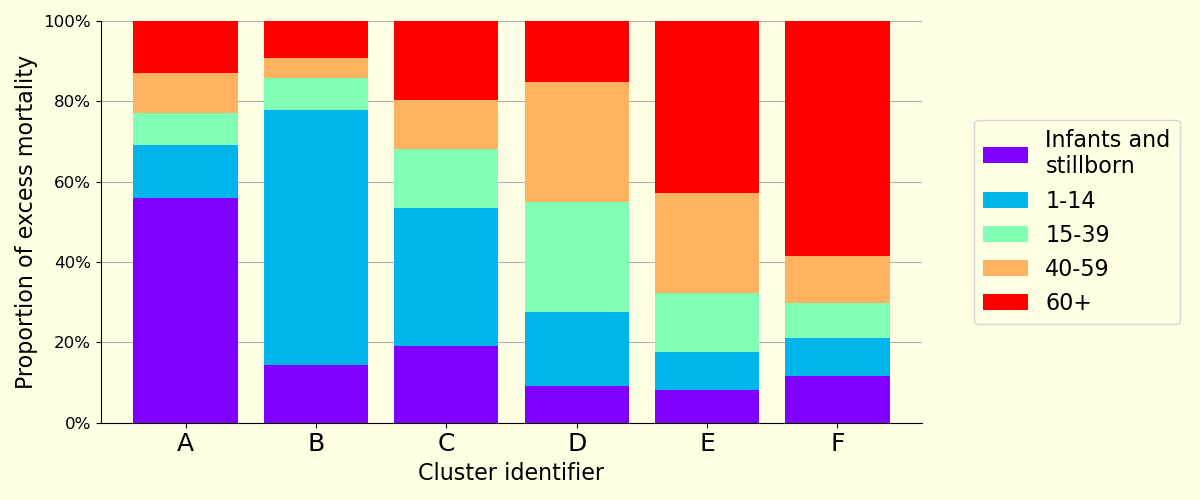

In [35]:
# Give dfMeans correct column-names
dfMeans.columns = ageGroupNames
dfMeans = dfMeans.rename(columns={'Infants_stillborn': 'Infants and\nstillborn'})

# Make a barchart illustrating each of the clusters
fig,ax = plt.subplots(figsize=(12,5))
(dfMeans * 100).plot.bar(ax=ax,stacked=True,width=0.8,cmap=cmapBar)
ax.set_axisbelow(True)
ax.set_ylim([0,100])
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
ax.set_xlabel('Cluster identifier',fontsize=16)
ax.set_ylabel('Proportion of excess mortality',fontsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax.tick_params(axis='y',labelsize=12)

plt.xticks(rotation=0)

# ax.set_xticklabels([clusterNameDict[x] for x in dfMeans.index.values])
ax.set_xticklabels([clusterNameDict[x] for x in curClusters])

fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs+'Supplementary_ClustersIllustration')

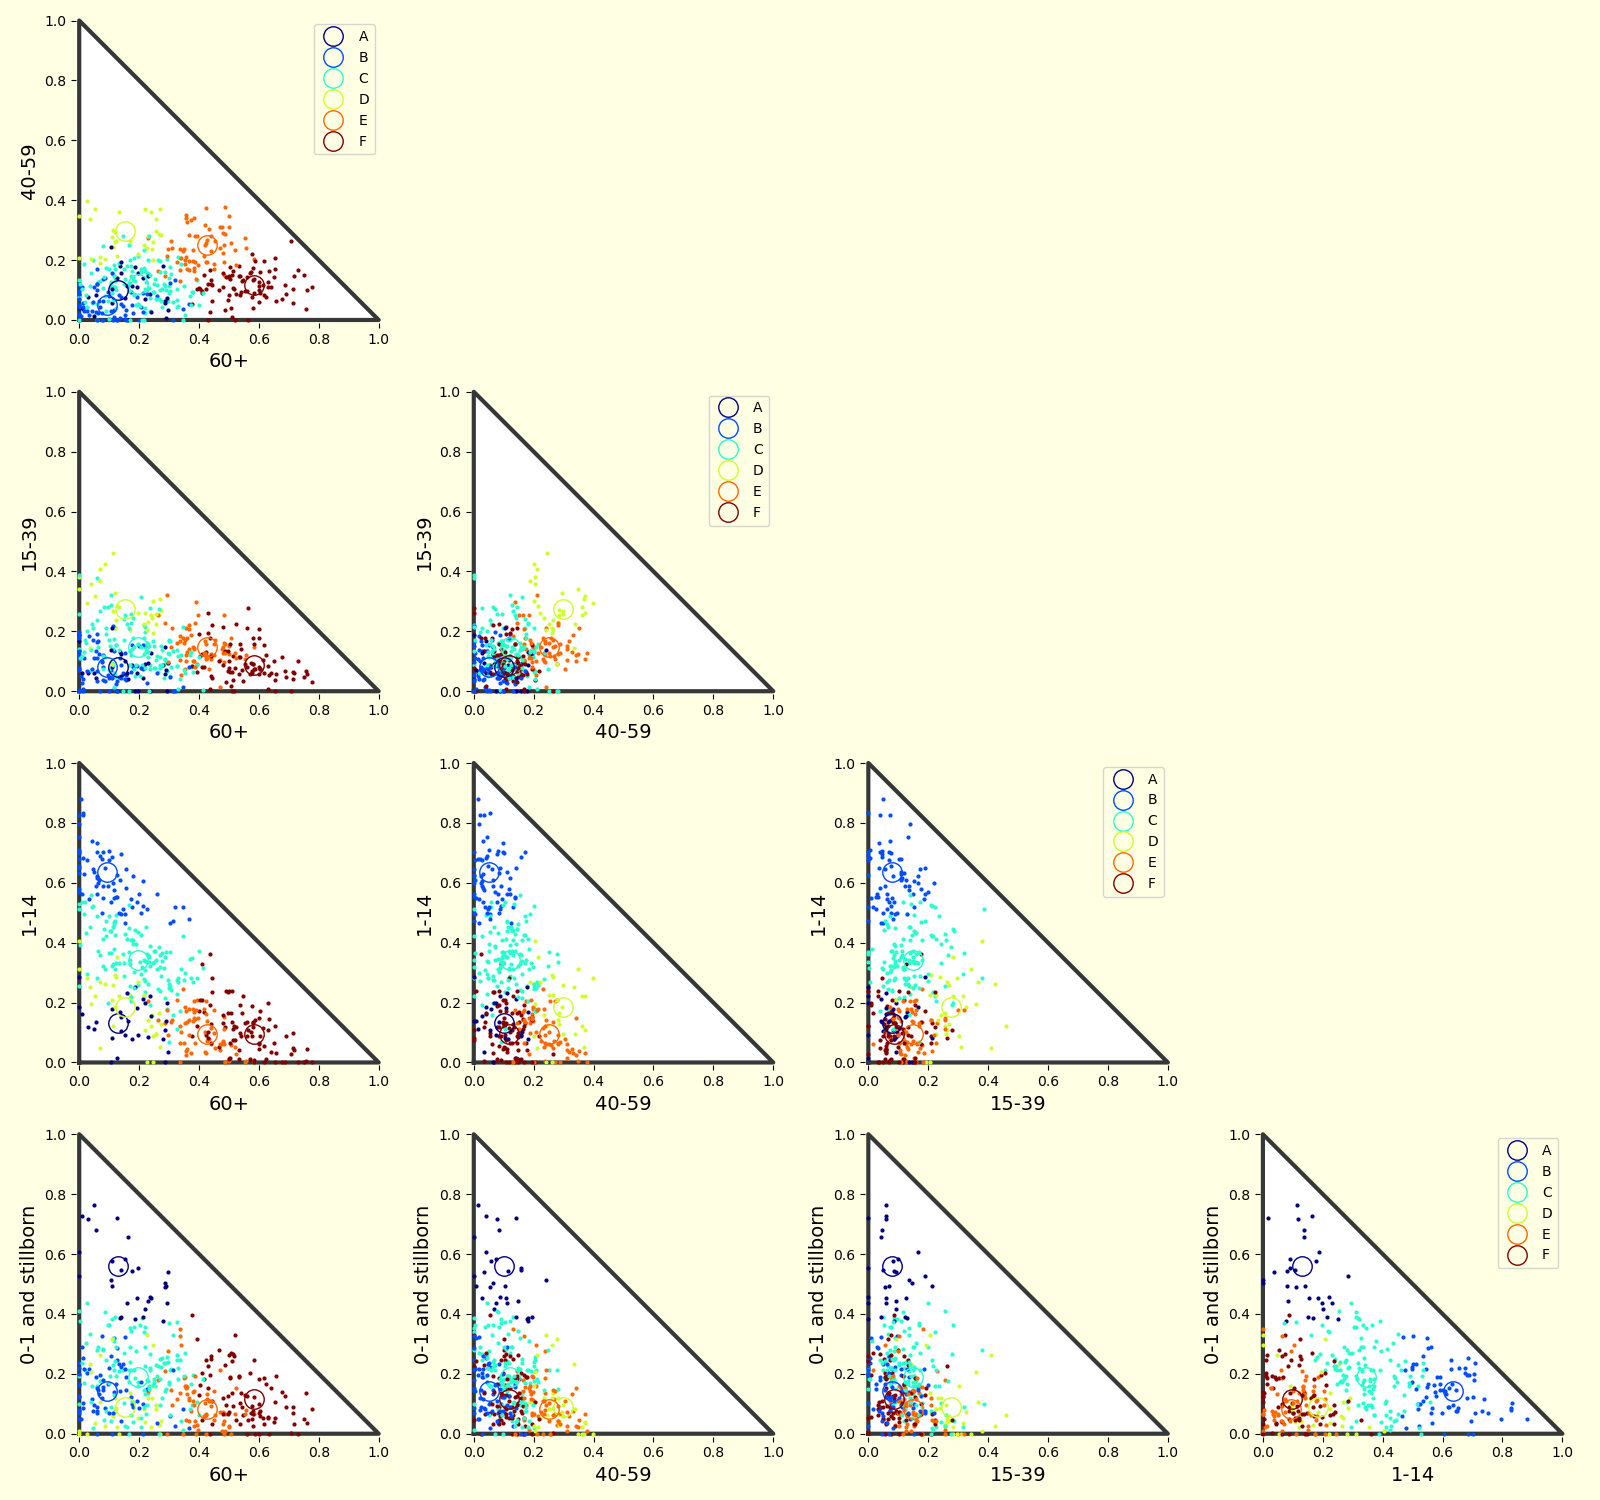

In [36]:
fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(16,15))
# fig,allAxes = plt.subplots(5,5)

showLabels = True
showLabels = False

for ax in allAxes.flatten():
    ax.set_aspect('equal', adjustable='box')


for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = curData[i]

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    curColor = cmap(invMap[r.Cluster]/numClusters)


    allAxes[0,0].plot(cur5,cur4,'.',ms=4,color=curColor)

    allAxes[1,0].plot(cur5,cur3,'.',ms=4,color=curColor)
    allAxes[1,1].plot(cur4,cur3,'.',ms=4,color=curColor)
    
    allAxes[2,0].plot(cur5,cur2,'.',ms=4,color=curColor)
    allAxes[2,1].plot(cur4,cur2,'.',ms=4,color=curColor)
    allAxes[2,2].plot(cur3,cur2,'.',ms=4,color=curColor)
    
    allAxes[3,0].plot(cur5,cur1,'.',ms=4,color=curColor)
    allAxes[3,1].plot(cur4,cur1,'.',ms=4,color=curColor)
    allAxes[3,2].plot(cur3,cur1,'.',ms=4,color=curColor)
    allAxes[3,3].plot(cur2,cur1,'.',ms=4,color=curColor)

    
    if showLabels:
        allAxes[0,0].text(cur5,cur4,curLabel,rotation=30,fontsize=6)
    
labelFontSize = 14
allAxes[3,3].set_xlabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[3,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[2,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[3,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[0,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[1,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[2,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[3,0].set_xlabel('60+',fontsize=labelFontSize)

allAxes[3,0].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,1].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,2].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[2,0].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,1].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[1,0].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[0,0].set_ylabel('40-59',fontsize=labelFontSize)

allAxes[0,1].axis(False)
allAxes[0,2].axis(False)
allAxes[0,3].axis(False)
allAxes[1,2].axis(False)
allAxes[1,3].axis(False)
allAxes[2,3].axis(False)



clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):

    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = curMean  

    curColor = cmap(i/numClusters)
    curLabel = clusterNameDict[clusterNum]

    
    allAxes[0,0].plot(mea5,mea4,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

    allAxes[1,0].plot(mea5,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[1,1].plot(mea4,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[2,0].plot(mea5,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,1].plot(mea4,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,2].plot(mea3,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[3,0].plot(mea5,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,1].plot(mea4,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,2].plot(mea3,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,3].plot(mea2,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)


allAxes[0,0].legend()
allAxes[1,1].legend()
allAxes[2,2].legend()
allAxes[3,3].legend()

for ax in allAxes.flatten():
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)

    ax.set_xlim([-0.01,1.01])
    ax.set_ylim([-0.01,1.01])

    ax.grid(False)
        
    coords = [[0,0],[1,0],[0,1],[0,0]]
    xs,ys = zip(*coords)
    ax.fill(xs,ys,color='w',zorder=-2)
        
allAxes[0,1].remove()
allAxes[0,2].remove()
allAxes[0,3].remove()
allAxes[1,2].remove()
allAxes[1,3].remove()
allAxes[2,3].remove()

if saveFigures:
    fig.savefig(pathFigs+'Supplementary_Pointcloud')

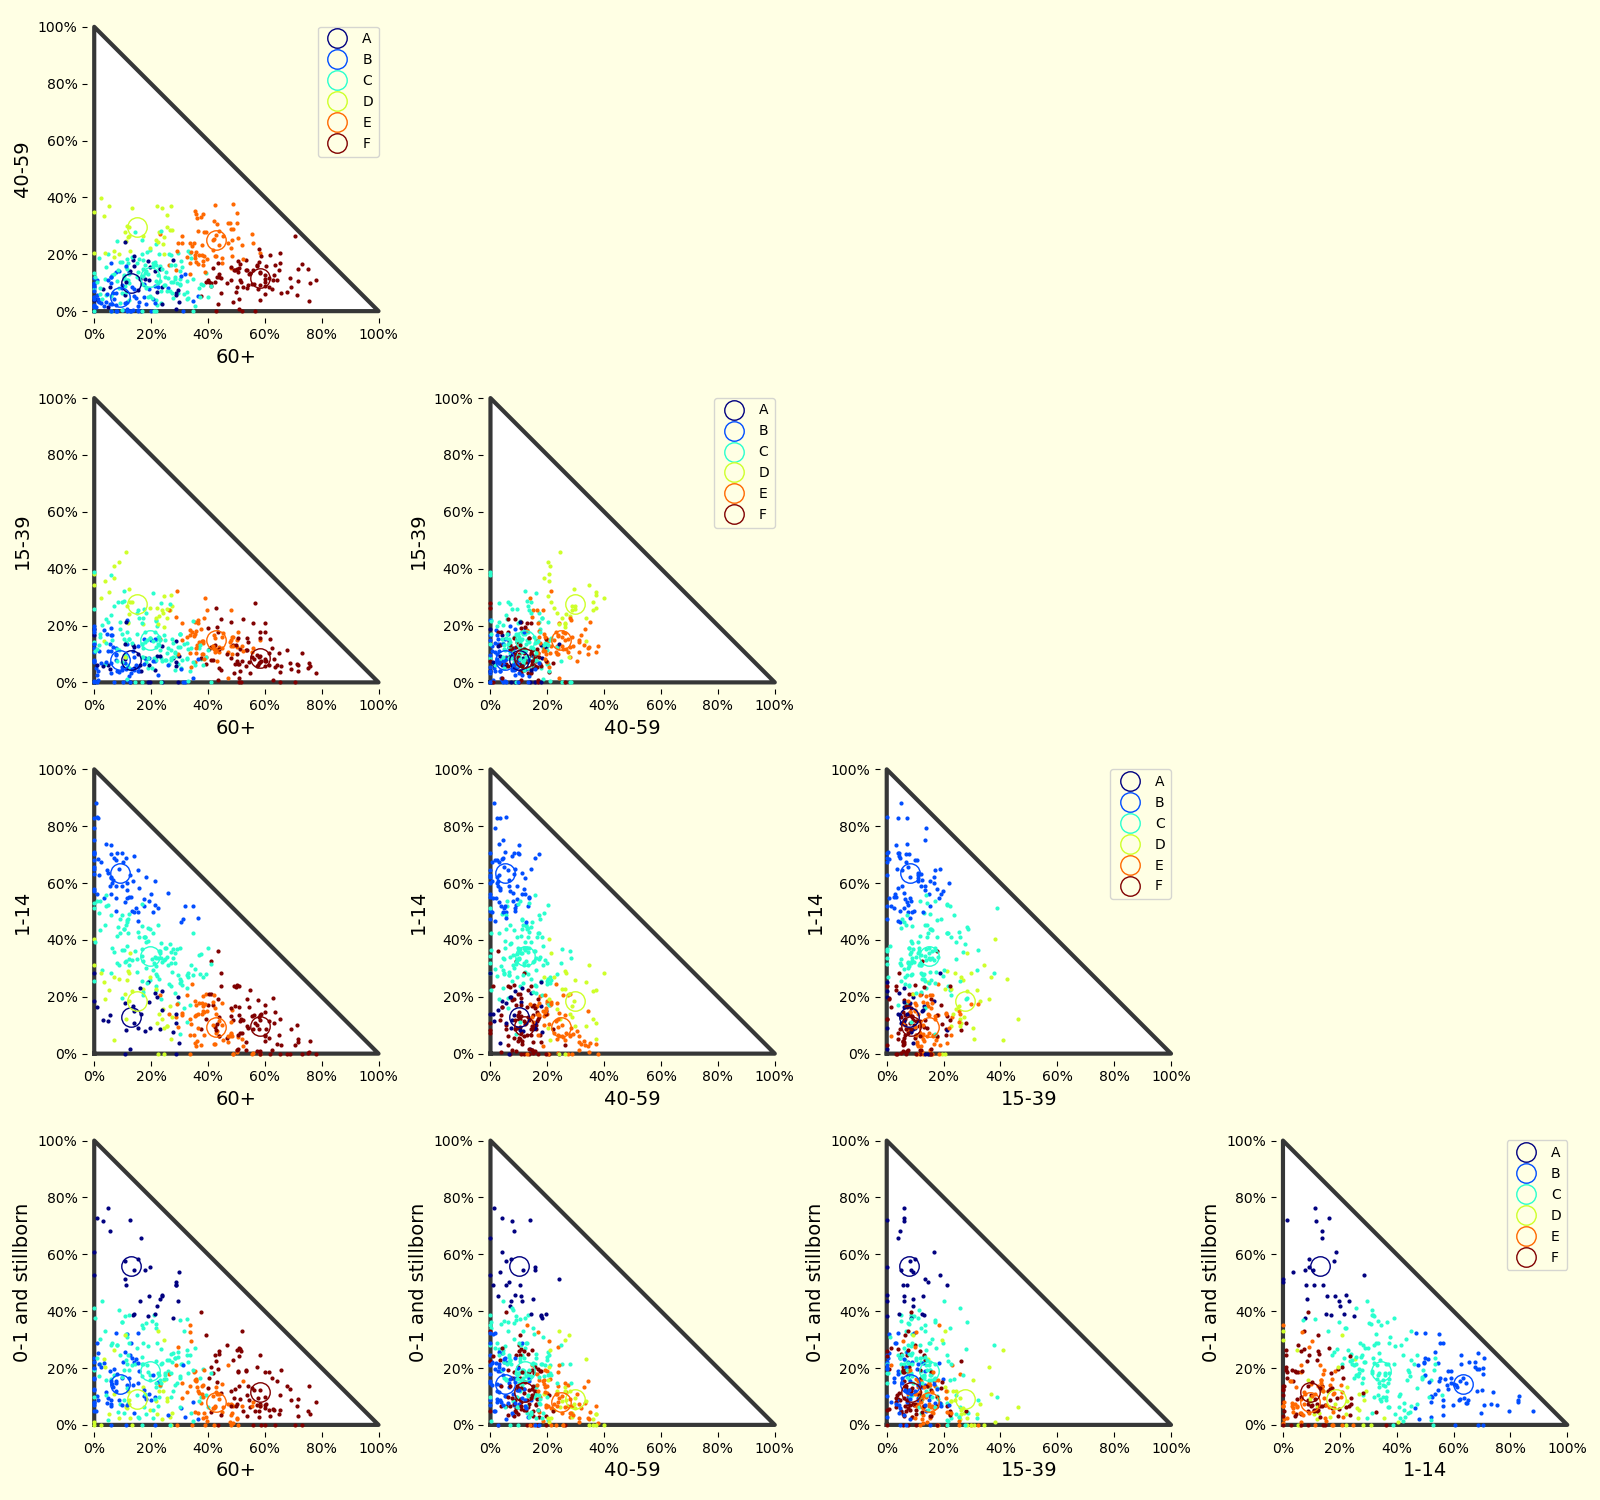

In [37]:
fig,allAxes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(16,15))
# fig,allAxes = plt.subplots(5,5)

showLabels = True
showLabels = False

for ax in allAxes.flatten():
    ax.set_aspect('equal', adjustable='box')

for i,r in dfCrisesLabel.iterrows():
    
    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    curColor = cmap(invMap[r.Cluster]/numClusters)
    

    allAxes[0,0].plot(cur5,cur4,'.',ms=4,color=curColor)

    allAxes[1,0].plot(cur5,cur3,'.',ms=4,color=curColor)
    allAxes[1,1].plot(cur4,cur3,'.',ms=4,color=curColor)
    
    allAxes[2,0].plot(cur5,cur2,'.',ms=4,color=curColor)
    allAxes[2,1].plot(cur4,cur2,'.',ms=4,color=curColor)
    allAxes[2,2].plot(cur3,cur2,'.',ms=4,color=curColor)
    
    allAxes[3,0].plot(cur5,cur1,'.',ms=4,color=curColor)
    allAxes[3,1].plot(cur4,cur1,'.',ms=4,color=curColor)
    allAxes[3,2].plot(cur3,cur1,'.',ms=4,color=curColor)
    allAxes[3,3].plot(cur2,cur1,'.',ms=4,color=curColor)

    
    if showLabels:
        allAxes[0,0].text(cur5,cur4,curLabel,rotation=30,fontsize=6)
    
labelFontSize = 14

allAxes[3,3].set_xlabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[3,2].set_xlabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[2,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[3,1].set_xlabel('40-59',fontsize=labelFontSize)
allAxes[0,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[1,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[2,0].set_xlabel('60+',fontsize=labelFontSize)
allAxes[3,0].set_xlabel('60+',fontsize=labelFontSize)

allAxes[3,0].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,1].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,2].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[3,3].set_ylabel('0-1 and stillborn',fontsize=labelFontSize)
allAxes[2,0].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,1].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[2,2].set_ylabel('1-14',fontsize=labelFontSize)
allAxes[1,0].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[1,1].set_ylabel('15-39',fontsize=labelFontSize)
allAxes[0,0].set_ylabel('40-59',fontsize=labelFontSize)


allAxes[0,1].axis(False)
allAxes[0,2].axis(False)
allAxes[0,3].axis(False)
allAxes[1,2].axis(False)
allAxes[1,3].axis(False)
allAxes[2,3].axis(False)



clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = clusterNameDict[clusterNum]


    
    allAxes[0,0].plot(mea5,mea4,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

    allAxes[1,0].plot(mea5,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[1,1].plot(mea4,mea3,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[2,0].plot(mea5,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,1].plot(mea4,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[2,2].plot(mea3,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    
    allAxes[3,0].plot(mea5,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,1].plot(mea4,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,2].plot(mea3,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    allAxes[3,3].plot(mea2,mea1,'o',color=curColor,mfc='none',markersize=14,label=curLabel)


allAxes[0,0].legend()
allAxes[1,1].legend()
allAxes[2,2].legend()
allAxes[3,3].legend()


for ax in allAxes.flatten():
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)

    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)
        
    coords = [[0,0],[100,0],[0,100],[0,0]]
    xs,ys = zip(*coords)
    ax.fill(xs,ys,color='w',zorder=-2)

        
allAxes[0,1].remove()
allAxes[0,2].remove()
allAxes[0,3].remove()
allAxes[1,2].remove()
allAxes[1,3].remove()
allAxes[2,3].remove()

if saveFigures:
    fig.savefig(pathFigs+'Supplementary_PointcloudPercent')

# Point-cloud figure for main text

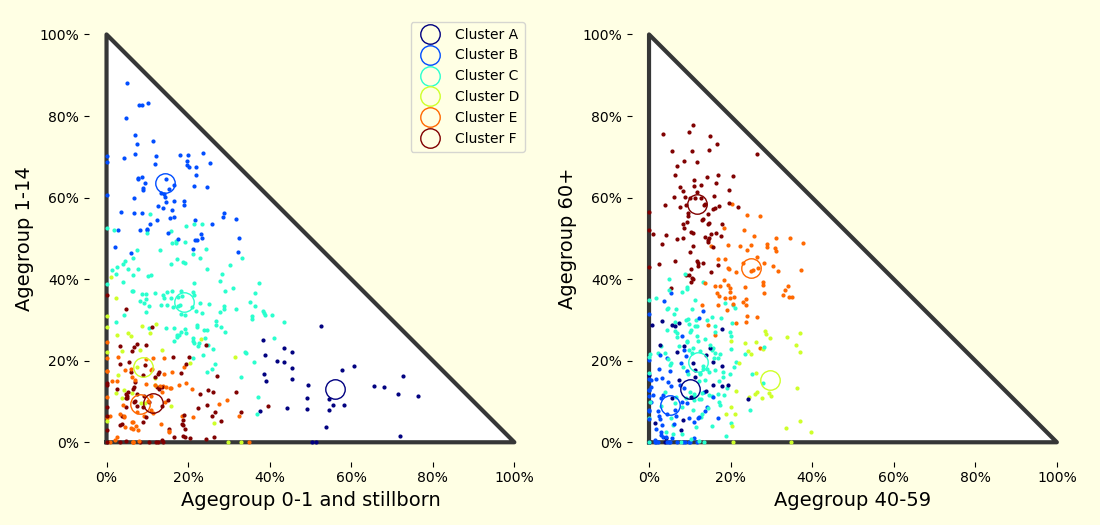

In [38]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5.25))

ax1.axis('equal')
ax2.axis('equal')

for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])


    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    
    ax1.plot(cur1,cur2,'.',ms=4,color=curColor)
    ax2.plot(cur4,cur5,'.',ms=4,color=curColor)

labelFontSize = 14


ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()

for ax in [ax1,ax2]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)
ax2.fill(xs,ys,color='w',zorder=-2)

fig.tight_layout()
    
if saveFigures:
    fig.savefig(pathFigs + 'Figure_PointcloudMainText')

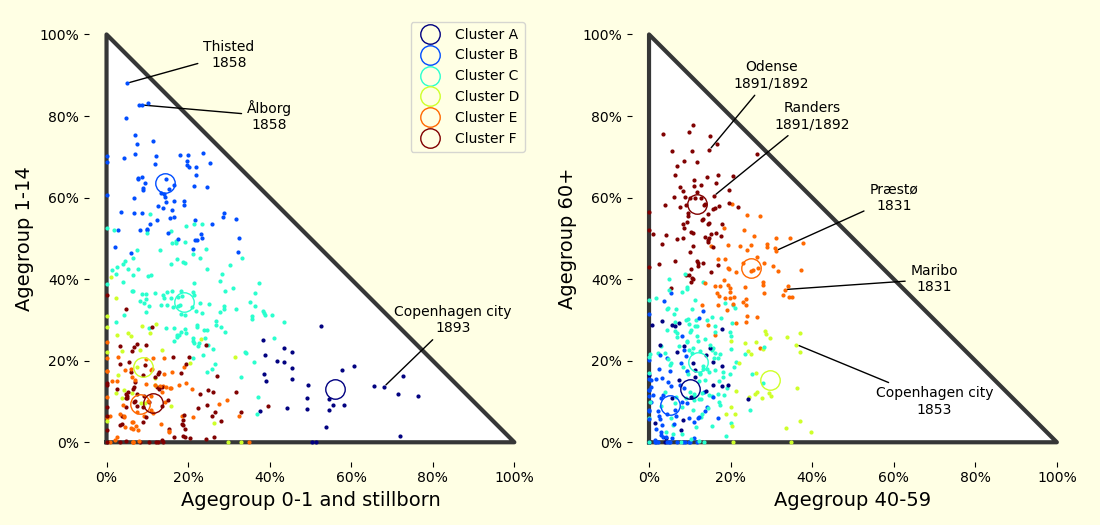

In [39]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,5.25))

ax1.axis('equal')
ax2.axis('equal')

for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)

    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    
    ax1.plot(cur1,cur2,'.',ms=4,color=curColor,zorder=2)
    ax2.plot(cur4,cur5,'.',ms=4,color=curColor,zorder=2)

labelFontSize = 14


ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()

for ax in [ax1,ax2]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

#### Label some selected crises
    
# # 1831

# First: Cholera, Copenhagen, row 0
i = 0
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')

# curLabel = 'Copenhagen city\n1853'
ax2.annotate(curLabel,(cur4,cur5),(70,10),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 1
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = 'Maribo\n1831'
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(70,40),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 2
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(60,60),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1858
i = 5
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(30,95),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'B'].index[2]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)
# # 1858
# i = 22
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax1.annotate(curLabel,(cur1,cur2),(40,80),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# High infants
# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'A'].index[0]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(85,30),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 32
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# # curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
# ax1.annotate(curLabel,(cur1,cur2),(60,55),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# # 1891
# i = 9
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
#     curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax2.annotate(curLabel,(cur4,cur5),(50,70),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 14
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[3]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 28
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[2]
r = dfCrises.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
ax2.annotate(curLabel,(cur4,cur5),(30,90),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)


# # 1891
# i = 8
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# # curLabel = r.Amt.split(' ')[0] + '\n1891-1892'
# ax2.annotate(curLabel,(cur4,cur5),(40,80),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)


coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)
ax2.fill(xs,ys,color='w',zorder=-2)

fig.tight_layout()
    
if saveFigures:
    fig.savefig(pathFigs + 'Figure_PointcloudMainText_Labels')

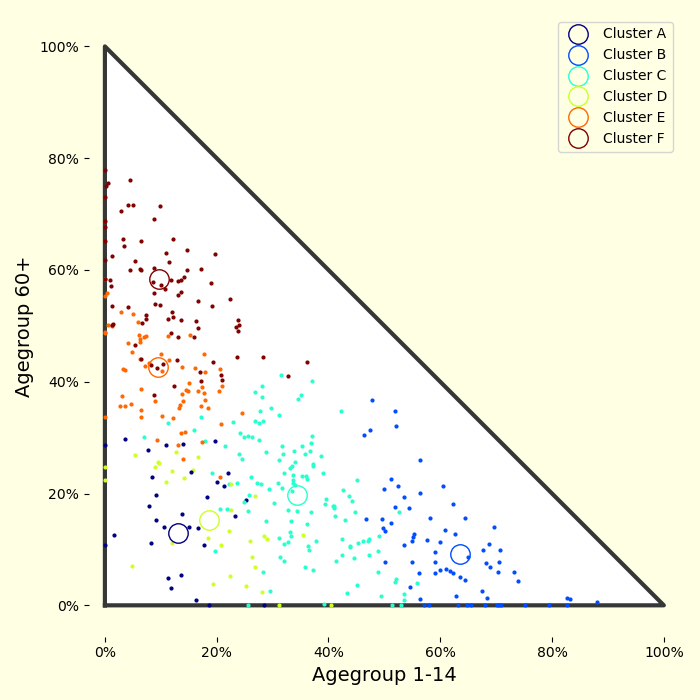

In [40]:
fig,ax1 = plt.subplots(figsize=(7,7))

ax1.axis('equal')

for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    ax1.plot(cur2,cur5,'.',ms=4,color=curColor)

labelFontSize = 14



ax1.set_xlabel('Agegroup 1-14',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea2,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    

ax1.legend()

ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
ax1.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

ax1.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
ax1.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)

# ax1.set_xlim([-0.01,1.01])
# ax1.set_ylim([-0.01,1.01])
ax1.set_xlim([-2.5,102.5])
ax1.set_ylim([-2.5,102.5])

ax1.xaxis.set_major_formatter(ticker.PercentFormatter())
ax1.yaxis.set_major_formatter(ticker.PercentFormatter())

ax1.grid(False)

coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)

fig.tight_layout()
    
if saveFigures:
    fig.savefig(pathFigs+'Figure_PointcloudMainTextExtra')

# Make combined figure used in main text

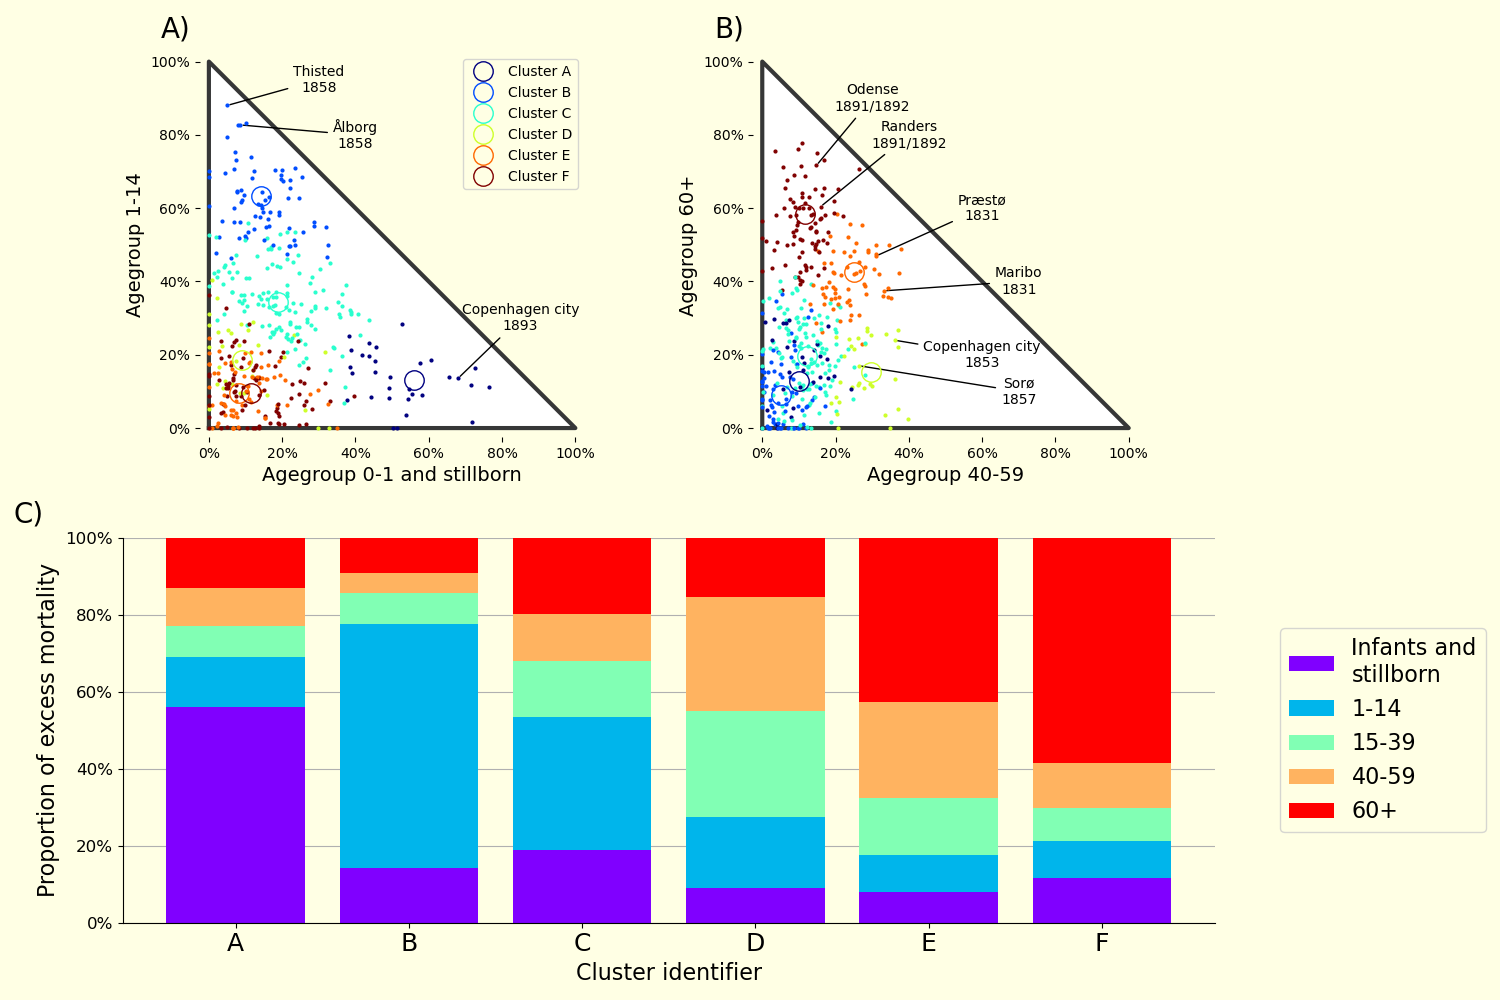

In [41]:
fig = plt.figure(figsize=(15,10)) 
ax3 = plt.subplot(212)
(dfMeans * 100).plot.bar(ax=ax3,stacked=True,width=0.8,cmap=cmapBar)
ax3.set_axisbelow(True)
ax3.set_ylim([0,100])
ax3.legend(bbox_to_anchor=(1.05,0.5),loc='center left',fontsize=16)
ax3.set_xlabel('Cluster identifier',fontsize=16)
ax3.set_ylabel('Proportion of excess mortality',fontsize=16)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
ax3.tick_params(axis='y',labelsize=12)

plt.xticks(rotation=0)


ax3.set_xticklabels([clusterNameDict[x] for x in curClusters])


ax1 = plt.subplot(221)
ax2 = plt.subplot(222)


ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')



for i,r in dfCrisesLabel.iterrows():

    (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])

    curLabel = r.Amt[:4]+', '+str(r.DayWithMostDeaths.year)
    
    
    curColor = cmap(invMap[r.Cluster]/numClusters)
    
    
    ax1.plot(cur1,cur2,'.',ms=4,color=curColor,zorder=2)
    ax2.plot(cur4,cur5,'.',ms=4,color=curColor,zorder=2)

labelFontSize = 14


ax1.set_xlabel('Agegroup 0-1 and stillborn',fontsize=labelFontSize)
ax1.set_ylabel('Agegroup 1-14',fontsize=labelFontSize)
ax2.set_xlabel('Agegroup 40-59',fontsize=labelFontSize)
ax2.set_ylabel('Agegroup 60+',fontsize=labelFontSize)


clusterNum = 0
for i,clusterNum in enumerate(range(numClusters)):
    
    curMean = dfMeans.iloc[clusterNum,:]
    
    
    mea1,mea2,mea3,mea4,mea5 = (100*curMean)

    curColor = cmap(i/numClusters)
    curLabel = 'Cluster '+clusterNameDict[clusterNum]

    ax1.plot(mea1,mea2,'o',color=curColor,mfc='none',markersize=14,label=curLabel)
    ax2.plot(mea4,mea5,'o',color=curColor,mfc='none',markersize=14,label=curLabel)

ax1.legend()

for ax in [ax1,ax2]:
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # ax.plot([0,1,0,0],[0,0,1,0],color='xkcd:dark grey',zorder=0)
    ax.plot([0,100,0,0],[0,0,100,0],color='xkcd:dark grey',zorder=0)

    ax.xaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    ax.yaxis.set_tick_params(which='both', labelbottom=True,labelsize=10)
    
    # ax.set_xlim([-0.01,1.01])
    # ax.set_ylim([-0.01,1.01])
    ax.set_xlim([-2.5,102.5])
    ax.set_ylim([-2.5,102.5])

    ax.xaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    ax.grid(False)

coords = [[0,0],[100,0],[0,100],[0,0]]
xs,ys = zip(*coords)
ax1.fill(xs,ys,color='w',zorder=-2)
ax2.fill(xs,ys,color='w',zorder=-2)


ax1.text(-0.1,1.04,'A)',fontsize=20,transform=ax1.transAxes)
ax2.text(-0.1,1.04,'B)',fontsize=20,transform=ax2.transAxes)
ax3.text(-0.1,1.04,'C)',fontsize=20,transform=ax3.transAxes)

fig.tight_layout()

if saveFigures:
    fig.savefig(pathFigs+'Figure_ClusteringCombinedFigure')

#### Label some selected crises

# First: Cholera, Copenhagen, row 0
i = 0
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# curLabel = 'Copenhagen city\n1853'
ax2.annotate(curLabel,(cur4,cur5),(60,20),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)


i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1857].index[2]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(70,10),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 1
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = 'Maribo\n1831'
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(70,40),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1831
i = 2
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(60,60),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1858
i = 5
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(30,95),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'B'].index[2]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)
# # 1858
# i = 22
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax1.annotate(curLabel,(cur1,cur2),(40,80),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# High infants
# i = 25
i = dfCrisesLabel[dfCrisesLabel.Cluster == 'A'].index[0]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax1.annotate(curLabel,(cur1,cur2),(85,30),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# i = 32
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# # curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# curLabel = 'Copenhagen city\n'+ str(r.DayWithMostDeaths.year)
# ax1.annotate(curLabel,(cur1,cur2),(60,55),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# # 1891
# i = 9
# r = dfCrisesLabel.loc[i]
# (cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
# curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
# if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
#     curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
# curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# ax2.annotate(curLabel,(cur4,cur5),(50,70),
#             arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 14
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[3]
r = dfCrisesLabel.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
ax2.annotate(curLabel,(cur4,cur5),(40,80),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)

# 1891
# i = 28
i = dfCrisesLabel[dfCrisesLabel.Start.dt.year == 1891].index[2]
r = dfCrises.loc[i]
(cur1,cur2,cur3,cur4,cur5) = (100*curData[i])
curLabel = r.Amt.split(' ')[0] + '\n'+ str(r.DayWithMostDeaths.year)
if (r.DayWithMostDeaths.year == 1891) | (r.DayWithMostDeaths.year == 1892):
    curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
curLabel = curLabel.replace('Staden','Copenhagen city').replace('Københavns','Copenhagen County')
# curLabel = r.Amt.split(' ')[0] + '\n1891/1892'
ax2.annotate(curLabel,(cur4,cur5),(30,90),
            arrowprops=dict(facecolor='xkcd:grey', arrowstyle='-'),ha='center',va='center',zorder=1)



fig.tight_layout()


if saveFigures:
    fig.savefig(pathFigs+'Figure_ClusteringCombinedFigure_Labels')
    

# Make illustrations of clusters

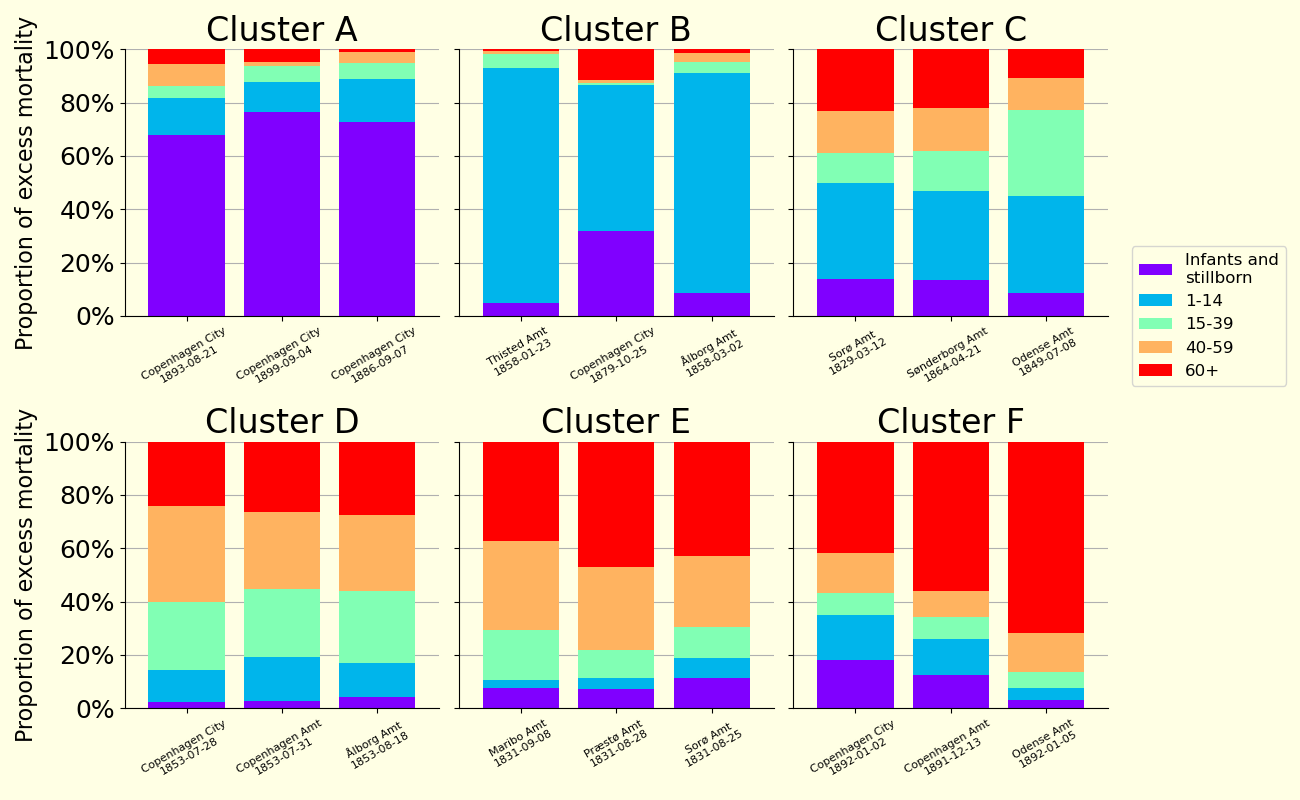

In [42]:

if (numClusters == 6):
    fig,allAxes = plt.subplots(2,3,figsize=(13,8),sharey=True)
elif (numClusters == 7):
    fig,allAxes = plt.subplots(2,4,figsize=(15,8),sharey=True)
    allAxes[1,3].axis(False)
elif (numClusters == 8):
    fig,allAxes = plt.subplots(2,4,figsize=(15,8),sharey=True)

# for i,ax in enumerate(allAxes.flatten()):
axIndex = 0
# for i in curSortIndex:
for i in clusterNameDict.values():

    ax = allAxes.flatten()[axIndex]
    axIndex += 1



    dfCurLabel = dfCrisesLabel.loc[dfCrisesLabel.Cluster == i].copy()

    dfCurLabel = dfCrisesLabel.loc[dfCrisesLabel.Cluster == i].copy()
    dfCurLabel['Amt'] = dfCurLabel.Amt.str.replace('Københavns Amt','Copenhagen Amt')
    dfCurLabel['Amt'] = dfCurLabel.Amt.str.replace('Staden København','Copenhagen City')
    

    testdf = fracdf.loc[dfCurLabel.index]

    testdf.columns = dfMeans.columns 


    (testdf.iloc[:3] * 100).plot.bar(ax=ax,stacked=True,width=0.8,legend=False,cmap=cmapBar)

    dfCurToTicks = dfCurLabel.loc[testdf.iloc[:3].index]
    curXlabels = dfCurToTicks.Amt + '\n' +dfCurToTicks.DayWithMostDeaths.dt.year.astype(str)
    curXlabels = dfCurToTicks.Amt + '\n' +dfCurToTicks.DayWithMostDeaths.astype(str)
    ax.set_xticklabels(curXlabels.values,rotation=30,fontsize=8)

    ax.set_axisbelow(True)
    ax.set_ylim([0,100])
    
    ax.set_ylabel('Proportion of excess mortality',fontsize=16)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d%%'))
    
    ax.set_title(f'Cluster {i}')

if (numClusters == 6):
    allAxes.flatten()[2].legend(bbox_to_anchor=(1.05,0),loc='center left',fontsize=12)
elif (numClusters == 7):
    ax = allAxes.flatten()[-1]
    (testdf.iloc[:3] * 0).plot.bar(ax=ax,stacked=True,width=0.8,legend=False,cmap=cmapBar)
    ax.legend(loc='center',fontsize=16)
elif (numClusters == 8):
    allAxes.flatten()[3].legend(bbox_to_anchor=(1.05,0),loc='center left',fontsize=12)


fig.tight_layout()
if saveFigures:
    fig.savefig(pathFigs+'ClustersExamples')